In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, uniform
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import stanza
import torch
from tqdm.notebook import tqdm, trange

from utils.depparse import DepParse
from utils.fakedata import FakeWorld, FakeData
from utils.semparse import SemParse

torch.cuda.empty_cache()

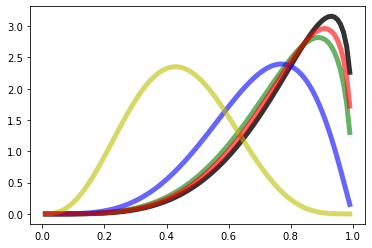

In [4]:
fig, ax = plt.subplots(1,1)
a, b = 5, 1.3
a5, b5 = 5, 1.4
a2, b2 = 5, 1.5
a3, b3 = 5, 2.2
a4, b4 = 4, 5

x = np.linspace(beta.ppf(0.01, 1, 1), beta.ppf(0.99, 1, 1), 100)
ax.plot(x, beta.pdf(x, a, b), 'k-', lw=5, alpha=0.8)
ax.plot(x, beta.pdf(x, a2, b2), 'g-', lw=5, alpha=0.6)
ax.plot(x, beta.pdf(x, a3, b3), 'b-', lw=5, alpha=0.6)
ax.plot(x, beta.pdf(x, a4, b4), 'y-', lw=5, alpha=0.6)
ax.plot(x, beta.pdf(x, a5, b5), 'r-', lw=5, alpha=0.6)
plt.savefig('images/classifier_distributions.png',bbox_inches='tight')
plt.show()

# How Much Does Vocab Size Affect Accuracy

In [5]:
p = stanza.Pipeline(lang="en", 
    processors={"tokenize": "spacy","mwt": "default","pos": "default","lemma": "default","depparse": "default"}
    )

2020-09-16 10:39:19 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-09-16 10:39:19 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | spacy     |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

2020-09-16 10:39:20 INFO: Use device: gpu
2020-09-16 10:39:20 INFO: Loading: tokenize
2020-09-16 10:39:21 INFO: Loading: pos
2020-09-16 10:39:25 INFO: Loading: lemma
2020-09-16 10:39:25 INFO: Loading: depparse
2020-09-16 10:39:27 INFO: Loading: sentiment
2020-09-16 10:39:28 INFO: Loading: ner
2020-09-16 10:39:29 INFO: Done loading processors!


In [6]:
thresholds = [0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92]
values = []
for n in trange(1,11):
    vals = []
    for t in tqdm(thresholds):
        acc_scores = []
        f1_scores = []
        for _ in trange(5):
            f = FakeWorld(n,n)
            d = FakeData(f,150)
            jd = "\n\n".join(d.utterances)
            dp = DepParse.parse(jd,parser=p)
            s = SemParse(threshold=t,parser=dp)
            s.fit(d.class_output, d.correct, joined_data=jd, arr_cols=d.arr_cols)
            prediction = s.predict()
            acc = accuracy_score(d.correct, prediction)
            f1 = f1_score(d.correct, prediction)
            acc_scores.append(acc)
            f1_scores.append(f1)
        vals.append((t,acc_scores,f1_scores))
    values.append((n, vals))

In [12]:
vv = [(x[0],[(y[0], np.mean(y[1]), np.mean(y[2])) for y in x[1]]) for x in values]
av = [[y[1] for y in x[1]] for x in vv]

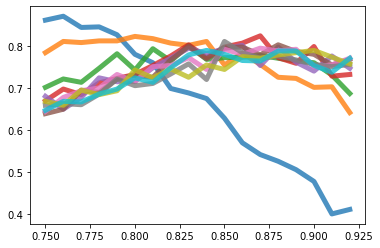

In [14]:
fig, ax = plt.subplots(1,1)
for a in av:
    ax.plot(thresholds, a, lw=5, alpha=0.8)
plt.savefig('images/best_thresholds.png', bbox_inches='tight')
plt.show()

In [16]:
lv = [x[0] for x in vv]
tv = [x[1][11][1] for x in vv]
thresholds[11]

0.86

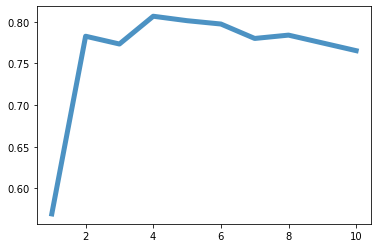

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(lv, tv, lw=5, alpha=0.8)
plt.savefig('images/wordcount_effects.png', bbox_inches='tight')
plt.show()